# 扩散模型

有时，考虑事物的最简单版本有助于更好地理解它的工作原理。 我们将在本笔记本中进行尝试，从“玩具”扩散模型开始，了解不同部分的工作原理，然后检查它们与更复杂的实现有何不同。

我们将看看
- 向数据添加噪声的过程
- 什么是 UNet，以及如何从头开始实现一个极小的 UNet
- 扩散模型训练
- 抽样理论

## 需要的包：

In [14]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## 数据

在这里，我们将使用一个非常小的数据集进行测试：mnist。 （老熟人了）

In [15]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, transform=torchvision.transforms.ToTensor())

In [16]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([9, 4, 3, 3, 9, 2, 2, 6])


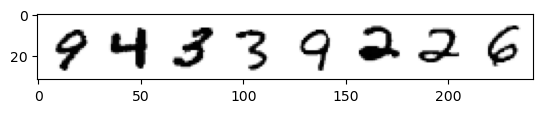

In [17]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

每个图像都是一个 28px x 28px 的黑白数字绘图，值范围从 0 到 1。

## 向数据添加噪声的过程

假装你没有读过任何扩散模型论文，但你知道这个过程涉及添加噪音。 你会怎么做？

我们可能想要一种简单的方法来控制添加噪声的数量。 那么，如果我们为要添加的“数量”噪声取一个参数，然后我们这样做：

`noise = torch.rand_like(x)` 

`noisy_x =  (1-amount)*x + amount*noise`

如果 amount = 0，我们将不做任何更改地取回输入。 如果 amount 达到 1，我们将返回没有输入 x 踪迹的噪声。 通过以这种方式将输入与噪声混合，我们将输出保持在相同的范围内（0 到 1）。 我们已证明一个大的amount的随机噪音的添加约等于一连串小的随机噪音的和。

我们可以很容易地实现这一点: 

In [18]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

并直观地查看结果，看看它是否按预期工作：

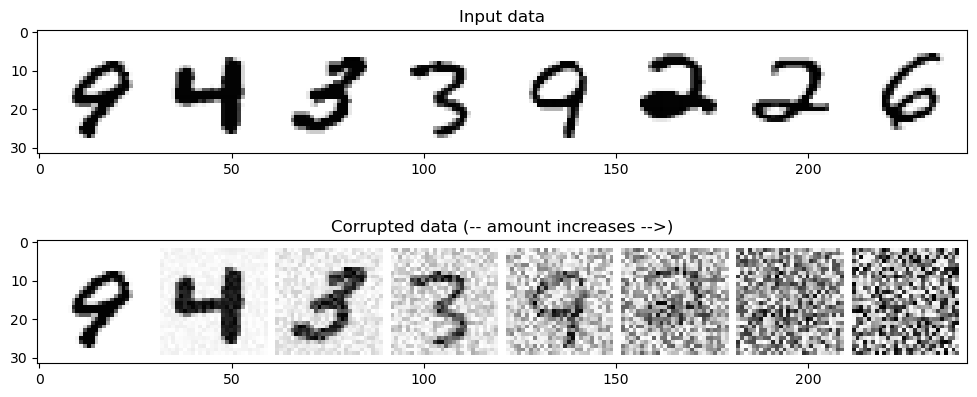

In [19]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

随着噪声量接近 1，我们的数据开始看起来像纯随机噪声。 但对于大多数噪声量，您可以很好地猜出数字。

## 模型

我们想要一个接受 28px 噪声图像并输出相同形状预测的模型。 这里一个流行的选择是称为 UNet 的架构。 [Originally invented for segmentation tasks in medical imagery](https://arxiv.org/abs/1505.04597), UNet 由一个“压缩路径”和一个“扩展路径”组成，数据通过它被压缩，数据通过它扩展回原始维度（类似于自动编码器），而且还具有允许信息和梯度流动的跳过连接 跨越不同层次。

一些 UNets 在每个阶段都有复杂的块，但对于这个玩具演示，我们将构建一个最小的示例，它接收一个单通道图像并通过下行路径上的三个卷积层（图表和代码中的 down_layers）和 三个在上行路径上的卷积层，下层和上层之间有跳过连接。 我们将使用最大池化进行下采样，使用 `nn.Upsample` 进行上采样，而不是依赖更复杂的 UNets 等可学习层。 这是粗略的架构，显示了每层输出中的通道数：

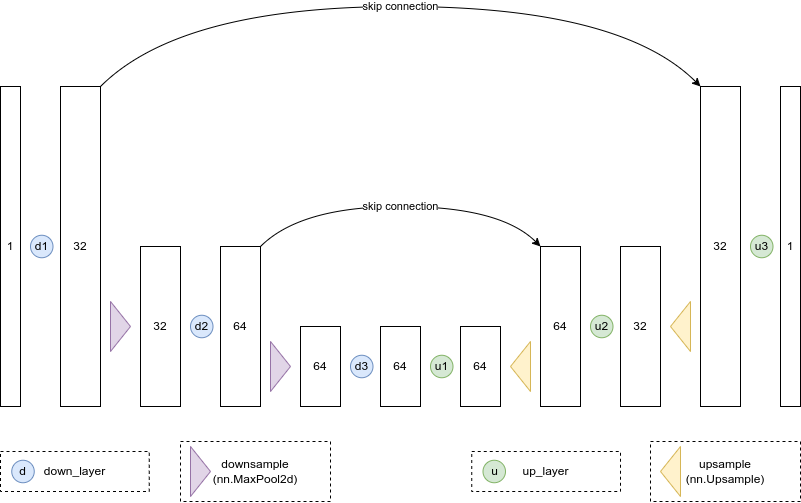

用代码所表示的样子:

In [20]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

正如我们预期的那样，我们可以验证输出shape与输入相同：

In [21]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

这个网络有超过 300,000 个参数：

In [22]:
sum([p.numel() for p in net.parameters()])

309057

如果需要，您可以探索更改每一层中的通道数量或交换不同的架构。

## 训练网络

那么模型究竟应该做什么呢？ 同样，对此有各种不同的看法，但对于这个演示，让我们选择一个简单的框架：给定一个添加噪声的输入noisy_x，模型应该输出它对原始 x 看起来像什么的最佳猜测。 我们将通过均方误差将其与实际值进行比较。

我们现在可以开始训练网络了。
- 获取一batch的数据
- 添加随机amounts的噪声
- 输入进unet模型
- 将模型预测与原图像进行比较以计算我们的损失
- 相应地更新模型的参数。

随意修改它，看看是否可以让它更好地工作！

Finished epoch 0. Average loss for this epoch: 0.026954
Finished epoch 1. Average loss for this epoch: 0.020477
Finished epoch 2. Average loss for this epoch: 0.018776
Finished epoch 3. Average loss for this epoch: 0.017841
Finished epoch 4. Average loss for this epoch: 0.017350
Finished epoch 5. Average loss for this epoch: 0.017064
Finished epoch 6. Average loss for this epoch: 0.016679
Finished epoch 7. Average loss for this epoch: 0.016412
Finished epoch 8. Average loss for this epoch: 0.016213
Finished epoch 9. Average loss for this epoch: 0.015857


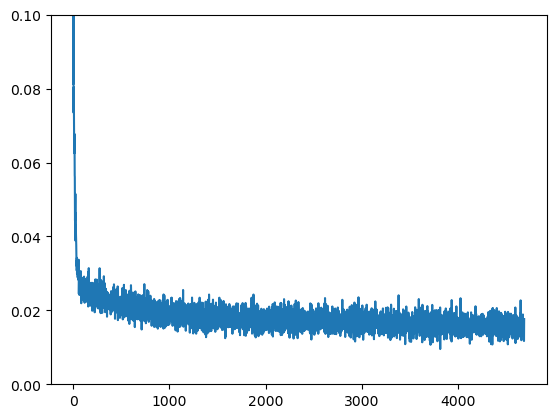

In [25]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

我们可以通过抓取一批数据，添加以不同的数量的噪音，然后查看模型预测来尝试查看模型预测的样子：

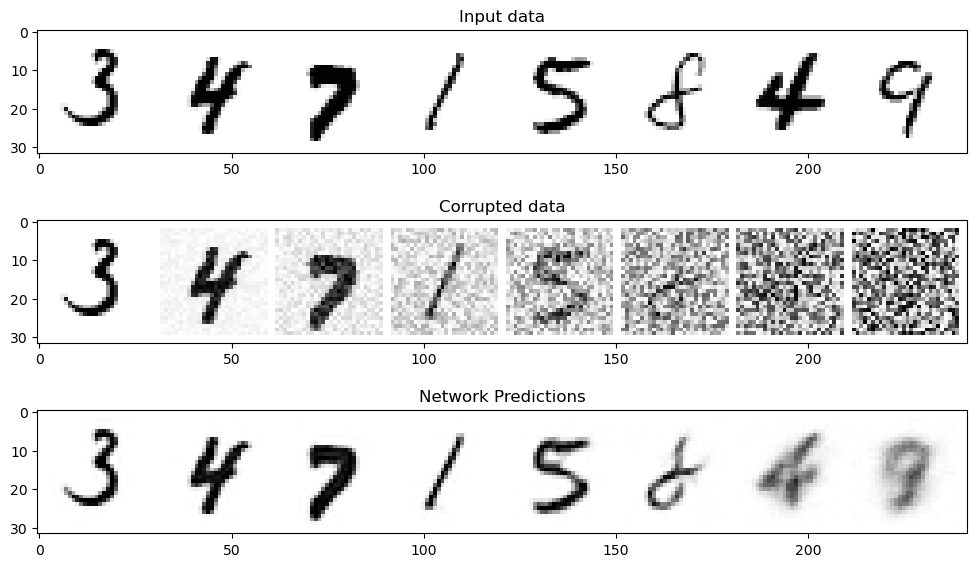

In [26]:
#@markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

您可以看到，对于较低的amount，预测非常好！ 但是随着amount级别变得非常高，模型可以使用的东西越来越少，当我们达到 amount=1 时，它会输出一个接近数据集均值的模糊混乱，以尝试对冲它对输出可能的赌注 看起来像...

## 采样

如果我们在高噪声水平下的预测不是很好，我们如何生成图像？

好吧，如果我们从随机噪声开始，查看模型预测，然后只向该预测移动少量——比如说，20%。现在我们有一个非常嘈杂的图像，其中可能有一丝结构，我们可以将其输入模型以获得新的预测。希望这个新预测比第一个预测稍微好一点（因为我们的起点噪声稍微少一点），所以我们可以用这个新的更好的预测再迈出一小步。

重复几次（如果一切顺利的话）我们就能得到一张图片！这是仅用 5 个步骤说明的过程，可视化每个阶段的模型输入（左）和预测的去噪图像（右）。 请注意，即使模型在第 1 步就预测了去噪图像，我们也只是将 x 移动到那里的一部分。经过几个步骤，结构出现并被细化，直到我们得到最终输出。

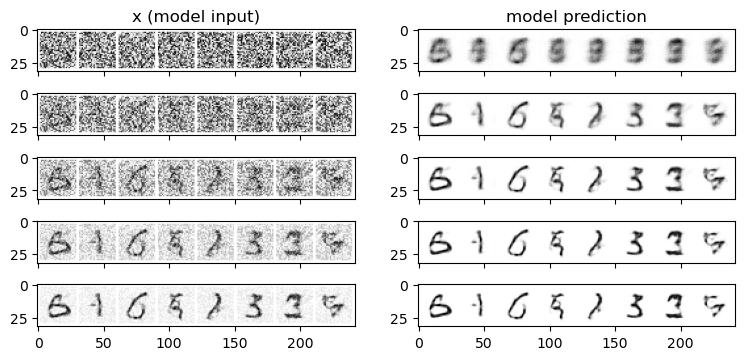

In [27]:
#@markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

我们可以把这个过程分成更多的步骤，并希望这样能得到更好的图像：

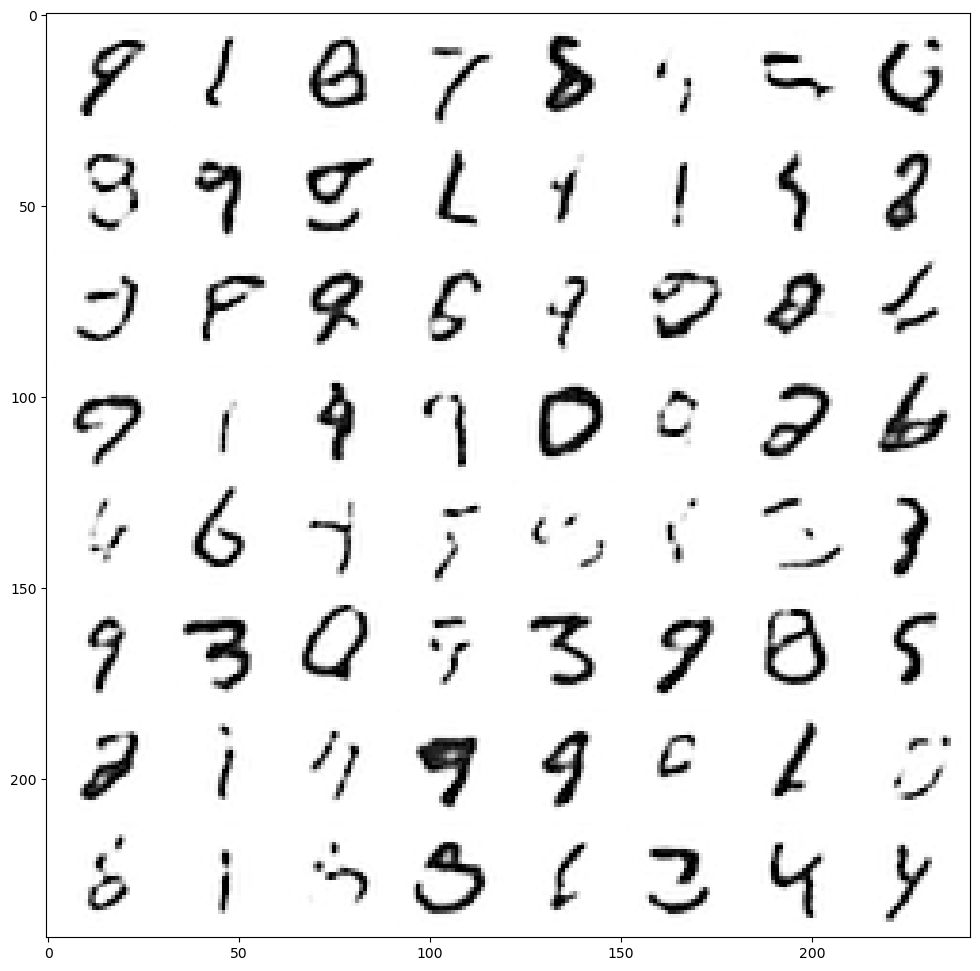

In [28]:
#@markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

不太好，但那里有一些可识别的数字！ 您可以试验更长时间的训练（比如20个epochs）并调整模型配置、学习率、优化器等。 另外，如果您想尝试稍微难一点的数据集，请不要忘记 fashionMNIST 是一种可行的替换。